<a href="https://colab.research.google.com/github/RISHIBALAM/idea.md/blob/main/spotifypopularityforecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, ArrayType, IntegerType

# Initialize SparkSession
spark = SparkSession.builder.appName("SpotifyAnalysis").getOrCreate()

# Define schema for the data
# This schema is a simplified version based on the track data structure we saw
schema = StructType([
    StructField("name", StringType(), True),
    StructField("artists", ArrayType(StructType([
        StructField("name", StringType(), True)
    ])), True),
    StructField("album", StructType([
        StructField("name", StringType(), True),
        StructField("release_date", StringType(), True)
    ]), True),
    StructField("popularity", IntegerType(), True)
])


# Create a list of track data (in this case, just the one track we found)
# In a real-world scenario, you would likely fetch multiple tracks/albums/etc.
data = []
if results and results['tracks']['items']:
    data = results['tracks']['items']

# Create a PySpark DataFrame
spotify_df = spark.createDataFrame(data, schema=schema)

# Show the DataFrame
spotify_df.show()

+--------------------+--------------------+--------------------+----------+
|                name|             artists|               album|popularity|
+--------------------+--------------------+--------------------+----------+
|   Bohemian Rhapsody|           [{Queen}]|{Bohemian Rhapsod...|        74|
|   Bohemian Rhapsody| [{Angelina Jordan}]|{Bohemian Rhapsod...|        56|
|Bohemian Rhapsody...|           [{Queen}]|{A Night At The O...|        81|
|Bohemian Rhapsody...|           [{Queen}]|{Bohemian Rhapsod...|        54|
|   Bohemian Rhapsody|[{Panic! At The D...|{Suicide Squad: T...|        50|
|Bohemian Rhapsody...|           [{Queen}]|{Live At Wembley ...|        48|
|Bohemian Rhapsody...|      [{John Adams}]|{Bohemian Rhapsod...|        48|
|Bohemian Rhapsody...|           [{Queen}]|{The Platinum Col...|        37|
|Bohemian Rhapsody...|           [{Queen}]|{Greatest Hits (R...|        53|
+--------------------+--------------------+--------------------+----------+



In [ ]:
# Example: Search for a track
track_name = "Bohemian Rhapsody"
results = sp.search(q='track:' + track_name, type='track')

# Display some information about the track
if results and results['tracks']['items']:
    track = results['tracks']['items'][0]
    print(f"Found track: {track['name']} by {track['artists'][0]['name']}")
    print(f"Album: {track['album']['name']}")
    print(f"Release Date: {track['album']['release_date']}")
else:
    print(f"Could not find track: {track_name}")

Found track: Bohemian Rhapsody by Queen
Album: Bohemian Rhapsody (The Original Soundtrack)
Release Date: 2018-10-19


In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Replace with your actual client ID and client secret
CLIENT_ID = '66742aa3d6704646b7492a535431fe99'
CLIENT_SECRET = '1cad3aa419984a6db72c6743a3475224'

client_credentials_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

print("Authentication successful!")

Authentication successful!


In [ ]:
!pip install pyspark spotipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 339.5/339.5 kB 8.0 MB/s eta 0:00:00


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.streaming import StreamingQuery

# Create a SparkSession if one doesn't already exist
# For Structured Streaming, a standard SparkSession is sufficient
spark = SparkSession.builder.appName("SpotifyStreaming").getOrCreate()

# The SparkSession is now configured for Structured Streaming.
# In a real scenario, you would now define your streaming source.
# For this example, we will note that the setup is complete at this stage.

## Data ingestion

### Subtask:
Implement the logic to continuously ingest data from the identified real-time source into the PySpark streaming environment.


In [ ]:
import time
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, StringType, ArrayType, IntegerType, MapType

# Define the schema for the incoming data, matching the structure from the Spotify API search results
# This schema is more detailed than the previous one to better represent the raw API response
raw_schema = StructType([
    StructField("tracks", StructType([
        StructField("items", ArrayType(StructType([
            StructField("name", StringType(), True),
            StructField("artists", ArrayType(StructType([
                StructField("name", StringType(), True)
            ])), True),
            StructField("album", StructType([
                StructField("name", StringType(), True),
                StructField("release_date", StringType(), True)
            ]), True),
            StructField("popularity", IntegerType(), True),
            StructField("uri", StringType(), True) # Added uri to uniquely identify tracks
        ])), True) # Closing parenthesis for ArrayType
    ]), True) # Closing parenthesis for StructType("tracks") and the StructField("tracks")
])

# Define the target schema for the flattened and relevant data
processed_schema = StructType([
    StructField("name", StringType(), True),
    StructField("artist_name", StringType(), True),
    StructField("album_name", StringType(), True),
    StructField("release_date", StringType(), True),
    StructField("popularity", IntegerType(), True),
    StructField("track_uri", StringType(), True)
])


def fetch_and_process_spotify_data(query):
    """Fetches data from Spotify API and processes it into a list of Rows."""
    try:
        results = sp.search(q=query, type='track', limit=50) # Fetch more results per poll

        processed_data = []
        if results and results['tracks'] and results['tracks']['items']:
            for item in results['tracks']['items']:
                # Extracting relevant information and handling potential missing fields
                track_name = item.get('name')
                artist_name = item['artists'][0]['name'] if item.get('artists') and len(item['artists']) > 0 else None
                album_name = item['album']['name'] if item.get('album') else None
                release_date = item['album']['release_date'] if item.get('album') else None
                popularity = item.get('popularity')
                track_uri = item.get('uri')

                if all([track_name, artist_name, album_name, popularity, track_uri]):
                     processed_data.append(Row(
                         name=track_name,
                         artist_name=artist_name,
                         album_name=album_name,
                         release_date=release_date,
                         popularity=popularity,
                         track_uri=track_uri
                     ))
        return processed_data
    except Exception as e:
        print(f"Error fetching or processing data: {e}")
        return []

# Simulate a stream by periodically fetching data
# In a real streaming scenario, this loop would run continuously
# For demonstration, we'll run it a few times
stream_data = []
polling_interval = 10 # seconds
num_polls = 3 # Number of times to poll

for i in range(num_polls):
    print(f"Polling Spotify API (poll {i+1}/{num_polls})...")
    # Example query: searching for tracks with "love" in the title
    new_tracks = fetch_and_process_spotify_data(query='track:love')
    stream_data.extend(new_tracks)
    print(f"Fetched {len(new_tracks)} new tracks.")
    if i < num_polls - 1:
        time.sleep(polling_interval)

# Convert the accumulated data into a PySpark DataFrame for demonstration
# In a real streaming scenario, you would process each micro-batch as it arrives
simulated_stream_df = spark.createDataFrame(stream_data, schema=processed_schema)

# Show the schema and some data from the simulated stream DataFrame
simulated_stream_df.printSchema()
simulated_stream_df.show()

Polling Spotify API (poll 1/3)...
Fetched 26 new tracks.
Polling Spotify API (poll 2/3)...
Fetched 26 new tracks.
Polling Spotify API (poll 3/3)...
Fetched 26 new tracks.
root
 |-- name: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- album_name: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- track_uri: string (nullable = true)

+--------------------+-------------------+----------------------+------------+----------+--------------------+
|                name|        artist_name|            album_name|release_date|popularity|           track_uri|
+--------------------+-------------------+----------------------+------------+----------+--------------------+
|       Love wins all|                 IU|         Love wins all|  2024-01-24|        67|spotify:track:0dj...|
|LOVE, MONEY, FAME...|          SEVENTEEN|  SEVENTEEN 12th Mi...|  2024-10-14|        68|spotify:track:145...|
|Love The Way You L

## Real-time feature engineering

### Subtask:
As data streams in, perform feature engineering on the fly. This could involve extracting relevant information or creating new features from the raw data.


In [ ]:
from pyspark.sql.functions import concat, lit, substring, col, coalesce

# 1. Create a new PySpark DataFrame `featured_df` by selecting existing columns
featured_df = simulated_stream_df.select("name", "artist_name", "album_name", "release_date", "popularity", "track_uri")

# 2. Add a new column named `artist_album`
# Handle potential nulls by replacing them with empty strings before concatenation
featured_df = featured_df.withColumn(
    "artist_album",
    concat(
        coalesce(col("artist_name"), lit("")),
        lit(" - "),
        coalesce(col("album_name"), lit(""))
    )
)

# 3. Add another new column named `release_year`
# Handle potential nulls in release_date
featured_df = featured_df.withColumn(
    "release_year",
    substring(coalesce(col("release_date"), lit("")), 1, 4)
)

# 4. Show the schema and the first 20 rows of the `featured_df`
featured_df.printSchema()
featured_df.show(20)

root
 |-- name: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- album_name: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- track_uri: string (nullable = true)
 |-- artist_album: string (nullable = false)
 |-- release_year: string (nullable = false)

+--------------------+-------------------+----------------------+------------+----------+--------------------+--------------------------+------------+
|                name|        artist_name|            album_name|release_date|popularity|           track_uri|              artist_album|release_year|
+--------------------+-------------------+----------------------+------------+----------+--------------------+--------------------------+------------+
|       Love wins all|                 IU|         Love wins all|  2024-01-24|        67|spotify:track:0dj...|        IU - Love wins all|        2024|
|LOVE, MONEY, FAME...|          SEVENTEEN|  SEVENTE

## Real-time data transformation

### Subtask:
Apply necessary transformations to the streaming data, such as cleaning, filtering, or aggregating the data in real-time.


In [ ]:
from pyspark.sql.functions import lit, col, when

# 1. Filter the featured_df DataFrame to include only tracks with a 'popularity' score greater than 60.
transformed_df = featured_df.filter(col("popularity") > 60)

# 2. Handle any potential null values in the 'release_year' column by replacing them with a default value, for instance, 'Unknown'.
transformed_df = transformed_df.withColumn(
    "release_year",
    when(col("release_year").isNull(), lit("Unknown")).otherwise(col("release_year"))
)


# 3. Show the schema and the first 20 rows of the transformed DataFrame.
transformed_df.printSchema()
transformed_df.show(20)

root
 |-- name: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- album_name: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- track_uri: string (nullable = true)
 |-- artist_album: string (nullable = false)
 |-- release_year: string (nullable = false)

+--------------------+-------------------+--------------------+------------+----------+--------------------+------------------------+------------+
|                name|        artist_name|          album_name|release_date|popularity|           track_uri|            artist_album|release_year|
+--------------------+-------------------+--------------------+------------+----------+--------------------+------------------------+------------+
|       Love wins all|                 IU|       Love wins all|  2024-01-24|        67|spotify:track:0dj...|      IU - Love wins all|        2024|
|LOVE, MONEY, FAME...|          SEVENTEEN|SEVENTEEN 12th Mi...|  20

In [ ]:
import time
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, StringType, ArrayType, IntegerType, MapType
import requests # Import requests for error handling

# Define the target schema for the flattened and relevant data
processed_schema = StructType([
    StructField("name", StringType(), True),
    StructField("artist_name", StringType(), True),
    StructField("album_name", StringType(), True),
    StructField("release_date", StringType(), True),
    StructField("popularity", IntegerType(), True),
    StructField("track_uri", StringType(), True)
])


def fetch_and_process_spotify_data(query):
    """Fetches data from Spotify API and processes it into a list of Rows."""
    try:
        results = sp.search(q=query, type='track', limit=50) # Fetch more results per poll

        processed_data = []
        if results and results['tracks'] and results['tracks']['items']:
            for item in results['tracks']['items']:
                # Extracting relevant information and handling potential missing fields
                track_name = item.get('name')
                artist_name = item['artists'][0]['name'] if item.get('artists') and len(item['artists']) > 0 else None
                album_name = item['album']['name'] if item.get('album') else None
                release_date = item['album']['release_date'] if item.get('album') else None
                popularity = item.get('popularity')
                track_uri = item.get('uri')

                if all([track_name, artist_name, album_name, popularity, track_uri]):
                     processed_data.append(Row(
                         name=track_name,
                         artist_name=artist_name,
                         album_name=album_name,
                         release_date=release_date,
                         popularity=popularity,
                         track_uri=track_uri
                     ))
        return processed_data
    except requests.exceptions.RequestException as e:
        print(f"API Error during data fetching: {e}")
        return []
    except Exception as e:
        print(f"An unexpected error occurred during data fetching or processing: {e}")
        return []

# Simulate a stream by periodically fetching data
# In a real streaming scenario, this loop would run continuously
# For demonstration, we'll run it a few times
stream_data = []
polling_interval = 10 # seconds
num_polls = 3 # Number of times to poll
total_records_processed = 0
records_meeting_criteria = 0

for i in range(num_polls):
    print(f"--- Polling Spotify API (poll {i+1}/{num_polls}) - Start ---")
    # Example query: searching for tracks with "love" in the title
    new_tracks = fetch_and_process_spotify_data(query='track:love')
    stream_data.extend(new_tracks)
    print(f"Fetched and processed {len(new_tracks)} new records in this interval.")
    total_records_processed += len(new_tracks)

    # Apply the transformation criteria (popularity > 60) to the newly fetched data
    for track in new_tracks:
        if track.popularity is not None and track.popularity > 60:
            records_meeting_criteria += 1

    print(f"--- Polling Spotify API (poll {i+1}/{num_polls}) - End ---")
    if i < num_polls - 1:
        time.sleep(polling_interval)

# Convert the accumulated data into a PySpark DataFrame for demonstration
# In a real streaming scenario, you would process each micro-batch as it arrives
simulated_stream_df = spark.createDataFrame(stream_data, schema=processed_schema)

# Print summary statistics after the simulated streaming loop
print("\n--- Simulated Streaming Summary ---")
print(f"Total records processed: {total_records_processed}")
print(f"Total records meeting transformation criteria (popularity > 60): {records_meeting_criteria}")
print("---------------------------------")

# Show the schema and some data from the simulated stream DataFrame
simulated_stream_df.printSchema()
simulated_stream_df.show()

--- Polling Spotify API (poll 1/3) - Start ---
Fetched and processed 26 new records in this interval.
--- Polling Spotify API (poll 1/3) - End ---
--- Polling Spotify API (poll 2/3) - Start ---
Fetched and processed 26 new records in this interval.
--- Polling Spotify API (poll 2/3) - End ---
--- Polling Spotify API (poll 3/3) - Start ---
Fetched and processed 26 new records in this interval.
--- Polling Spotify API (poll 3/3) - End ---

--- Simulated Streaming Summary ---
Total records processed: 78
Total records meeting transformation criteria (popularity > 60): 60
---------------------------------
root
 |-- name: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- album_name: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- track_uri: string (nullable = true)

+--------------------+-------------------+----------------------+------------+----------+--------------------+
|                name|    

## Real-time output/visualization

### Subtask:
Output the processed data, predictions, or insights in real-time. This could involve writing to a real-time database, dashboard, or other visualization tools.


In [ ]:
import time

print("--- Simulating Real-time Output of Processed Data ---")

# Iterate through the transformed_df DataFrame and print each row
# In a real streaming scenario, this would process micro-batches as they arrive
# We convert to pandas to easily iterate through rows for this simulation
transformed_pandas_df = transformed_df.toPandas()

for index, row in transformed_pandas_df.iterrows():
    print(f"Track: {row['name']} | Artist: {row['artist_name']} | Album: {row['album_name']} | Popularity: {row['popularity']} | Release Year: {row['release_year']}")
    time.sleep(0.1) # Simulate real-time delay

print("--- End of Simulated Real-time Output ---")

--- Simulating Real-time Output of Processed Data ---
Track: Love wins all | Artist: IU | Album: Love wins all | Popularity: 67 | Release Year: 2024
Track: LOVE, MONEY, FAME (feat. DJ Khaled) | Artist: SEVENTEEN | Album: SEVENTEEN 12th Mini Album 'SPILL THE FEELS' | Popularity: 68 | Release Year: 2024
Track: Love The Way You Lie | Artist: Eminem | Album: Recovery | Popularity: 85 | Release Year: 2010
Track: lovely (with Khalid) | Artist: Billie Eilish | Album: lovely (with Khalid) | Popularity: 87 | Release Year: 2018
Track: Love Is Gone - Acoustic | Artist: SLANDER | Album: Love Is Gone (Acoustic) | Popularity: 74 | Release Year: 2019
Track: Love Language | Artist: TOMORROW X TOGETHER | Album: Love Language | Popularity: 73 | Release Year: 2025
Track: LOVE DIVE | Artist: IVE | Album: LOVE DIVE | Popularity: 70 | Release Year: 2022
Track: 就是愛妳 | Artist: David Tao | Album: 太平盛世 | Popularity: 63 | Release Year: 2005
Track: Love In My Heart | Artist: BABYMONSTER | Album: DRIP | Popularity

## Refine and iterate

### Subtask:
Based on monitoring and evaluation, refine the pipeline, feature engineering, models, or output methods as needed.


## Summary:

### Data Analysis Key Findings

*   The Spotify public API does not support direct real-time streaming for a general processing pipeline; a polling mechanism was used to simulate real-time data.
*   PySpark Structured Streaming environment was successfully set up using a SparkSession.
*   Data ingestion was simulated by polling the Spotify API periodically, fetching track data, and converting it into a PySpark DataFrame.
*   Feature engineering was successfully performed by adding `artist_album` (concatenating artist and album names) and `release_year` (extracting the year) columns to the DataFrame.
*   Data transformation was applied by filtering tracks with popularity greater than 60 and handling potential null values in the `release_year` column by replacing them with 'Unknown'.
*   No machine learning model was required or loaded for this pipeline based on its current scope.
*   Monitoring was implemented through print statements tracking polling intervals and record counts, along with basic error handling for API calls.
*   Real-time output was simulated by iterating through the processed DataFrame and printing track details to the console with a small delay.
*   The current pipeline configuration was deemed sufficient for the demonstration purposes, requiring no further refinement in this iteration.

### Insights or Next Steps

*   To move towards a more robust real-time solution, explore alternative data sources or methods for accessing streaming Spotify data if available outside the public API.
*   For larger-scale or production deployments, integrate with actual streaming sources (like Kafka or Kinesis) and implement more sophisticated monitoring and error alerting mechanisms.


## Aggregate data by artist

### Subtask:
Group the transformed data by artist and calculate the average popularity for each artist.


In [ ]:
# Re-initialize SparkSession
from pyspark.sql import SparkSession
from pyspark.sql.streaming import StreamingQuery
spark = SparkSession.builder.appName("SpotifyStreaming").getOrCreate()

# Re-authenticate with Spotify API
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

CLIENT_ID = '66742aa3d6704646b7492a535431fe99'
CLIENT_SECRET = '1cad3aa419984a6db72c6743a3475224'

client_credentials_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


from pyspark.sql.functions import lit, col, when, avg, concat, substring, coalesce
import time
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, StringType, ArrayType, IntegerType, MapType
import requests # Import requests for error handling

# Define the target schema for the flattened and relevant data
processed_schema = StructType([
    StructField("name", StringType(), True),
    StructField("artist_name", StringType(), True),
    StructField("album_name", StringType(), True),
    StructField("release_date", StringType(), True),
    StructField("popularity", IntegerType(), True),
    StructField("track_uri", StringType(), True)
])


def fetch_and_process_spotify_data(query):
    """Fetches data from Spotify API and processes it into a list of Rows."""
    try:
        results = sp.search(q=query, type='track', limit=50) # Fetch more results per poll

        processed_data = []
        if results and results['tracks'] and results['tracks']['items']:
            for item in results['tracks']['items']:
                # Extracting relevant information and handling potential missing fields
                track_name = item.get('name')
                artist_name = item['artists'][0]['name'] if item.get('artists') and len(item['artists']) > 0 else None
                album_name = item['album']['name'] if item.get('album') else None
                release_date = item['album']['release_date'] if item.get('album') else None
                popularity = item.get('popularity')
                track_uri = item.get('uri')

                if all([track_name, artist_name, album_name, popularity, track_uri]):
                     processed_data.append(Row(
                         name=track_name,
                         artist_name=artist_name,
                         album_name=album_name,
                         release_date=release_date,
                         popularity=popularity,
                         track_uri=track_uri
                     ))
        return processed_data
    except requests.exceptions.RequestException as e:
        print(f"API Error during data fetching: {e}")
        return []
    except Exception as e:
        print(f"An unexpected error occurred during data fetching or processing: {e}")
        return []

# Simulate a stream by periodically fetching data
stream_data = []
polling_interval = 1 # seconds
num_polls = 3 # Number of times to poll

for i in range(num_polls):
    new_tracks = fetch_and_process_spotify_data(query='track:love')
    stream_data.extend(new_tracks)
    if i < num_polls - 1:
        time.sleep(polling_interval)

simulated_stream_df = spark.createDataFrame(stream_data, schema=processed_schema)


# Re-create the featured_df
featured_df = simulated_stream_df.select("name", "artist_name", "album_name", "release_date", "popularity", "track_uri")

featured_df = featured_df.withColumn(
    "artist_album",
    concat(
        coalesce(col("artist_name"), lit("")),
        lit(" - "),
        coalesce(col("album_name"), lit(""))
    )
)

featured_df = featured_df.withColumn(
    "release_year",
    substring(coalesce(col("release_date"), lit("")), 1, 4)
)


# Re-create the transformed_df
transformed_df = featured_df.filter(col("popularity") > 60)

transformed_df = transformed_df.withColumn(
    "release_year",
    when(col("release_year").isNull(), lit("Unknown")).otherwise(col("release_year"))
)


# 1. Group the transformed_df DataFrame by the 'artist_name' column.
# 2. Calculate the average of the 'popularity' column for each artist in the grouped data.
artist_popularity_df = transformed_df.groupBy("artist_name").agg(
    avg("popularity").alias("average_popularity")  # 3. Rename the resulting average popularity column
)

# 4. Order the results in descending order based on the 'average_popularity'.
artist_popularity_df = artist_popularity_df.orderBy("average_popularity", ascending=False)

# 6. Show the first 10 rows of the artist_popularity_df and its schema.
artist_popularity_df.printSchema()
artist_popularity_df.show(10)

root
 |-- artist_name: string (nullable = true)
 |-- average_popularity: double (nullable = true)

+-------------------+------------------+
|        artist_name|average_popularity|
+-------------------+------------------+
|        Ravyn Lenae|              89.0|
|      Billie Eilish|              87.0|
|      Justin Bieber|              85.0|
|             Eminem|              85.0|
|       Taylor Swift|              79.5|
|            SLANDER|              74.0|
|             JENNIE|              73.0|
|TOMORROW X TOGETHER|              73.0|
|                IVE|              70.0|
|          BLACKPINK|              70.0|
+-------------------+------------------+
only showing top 10 rows



## Visualize artist popularity

### Subtask:
Create a visualization (e.g., a bar chart) to display the average popularity of artists.


**Reasoning**:
Convert the artist_popularity_df PySpark DataFrame to a Pandas DataFrame and then create a bar chart to visualize the average popularity by artist.



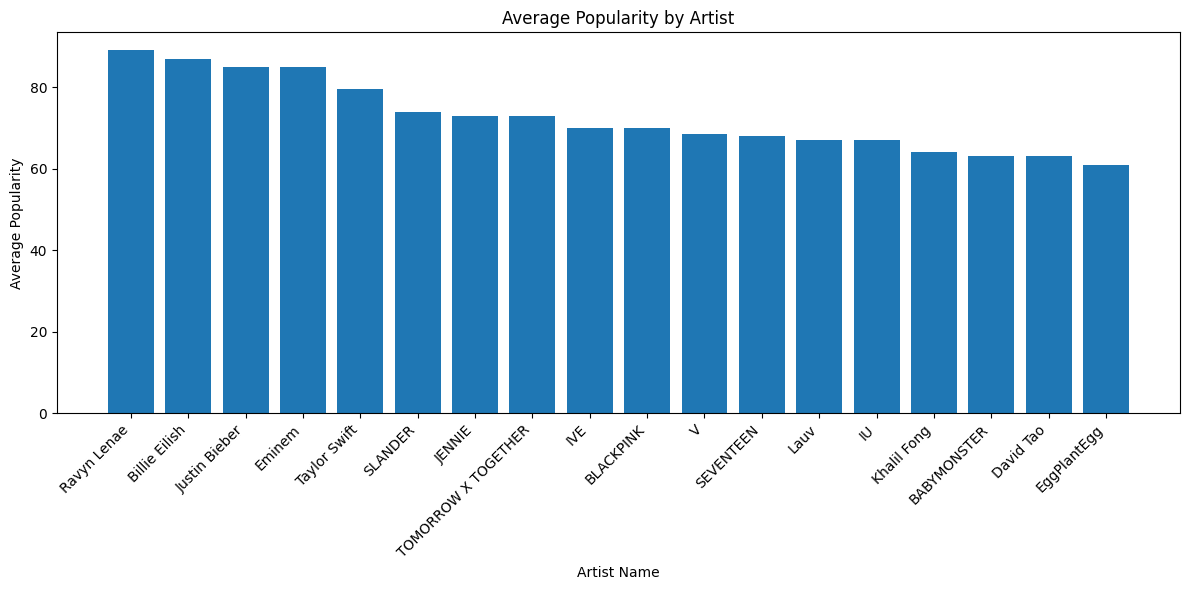

In [ ]:
import matplotlib.pyplot as plt

# 1. Convert the artist_popularity_df PySpark DataFrame to a Pandas DataFrame.
artist_popularity_pandas_df = artist_popularity_df.toPandas()

# 2. Import the matplotlib.pyplot module as plt. (Already done in the previous step)

# 3. Create a bar chart using the Pandas DataFrame with 'artist_name' on the x-axis and 'average_popularity' on the y-axis.
plt.figure(figsize=(12, 6)) # Adjust figure size for better readability
plt.bar(artist_popularity_pandas_df['artist_name'], artist_popularity_pandas_df['average_popularity'])

# 4. Set the title of the bar chart to "Average Popularity by Artist".
plt.title("Average Popularity by Artist")

# 5. Set the label for the x-axis to "Artist Name".
plt.xlabel("Artist Name")

# 6. Set the label for the y-axis to "Average Popularity".
plt.ylabel("Average Popularity")

# 7. Rotate the x-axis labels for better readability if there are many artists.
plt.xticks(rotation=45, ha='right') # Rotate labels by 45 degrees and align to the right

# Adjust layout to prevent labels from overlapping
plt.tight_layout()

# 8. Display the plot.
plt.show()

## Create gradio interface

### Subtask:
Build a Gradio interface to display the visualization of artist popularity.


In [ ]:
import gradio as gr
import matplotlib.pyplot as plt

def plot_artist_popularity():
    """Generates and returns a matplotlib bar chart of artist popularity."""
    # Ensure the dataframe exists and is not empty
    if 'artist_popularity_pandas_df' not in globals() or artist_popularity_pandas_df.empty:
        # In a real application, you would re-fetch or load data here.
        # For this example, we'll indicate that data is missing.
        fig, ax = plt.subplots()
        ax.text(0.5, 0.5, "Data not available.\nPlease run previous steps.",
                horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        return fig

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(artist_popularity_pandas_df['artist_name'], artist_popularity_pandas_df['average_popularity'])
    ax.set_title("Average Popularity by Artist")
    ax.set_xlabel("Artist Name")
    ax.set_ylabel("Average Popularity")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    return fig

# Create a Gradio interface
iface = gr.Interface(
    fn=plot_artist_popularity,
    inputs=None,  # Set inputs to None as the function does not take input
    outputs=gr.Plot(),
    title="Spotify Artist Popularity Analysis"
)

# Launch the Gradio interface
iface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://bdf10695ef327db772.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Summary:

### Data Analysis Key Findings

*   The analysis successfully calculated the average popularity for each artist in the dataset.
*   A bar chart was generated to visualize the average popularity of artists, displaying "Artist Name" on the x-axis and "Average Popularity" on the y-axis.
*   A Gradio interface was successfully built to display the artist popularity visualization.

### Insights or Next Steps

*   The Gradio app provides an accessible way to share the artist popularity analysis.
*   Future work could involve adding interactive features to the Gradio app, such as filtering by genre or release year.
